# **Machine Learning using scikit-learn**

As a reminder, below are the following best practices we should follow when performing Machine Learning in Python:

1. Perform all pre-processing steps within cross-validation
2. Measure model performance (and model selection) using cross-validation
3. Follow literate programming practices to make code readable and make collaboration easier

## Problem Formulation

In this example, we will use IBM's HR Attrition dataset, available here: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset.
The dataset contains data on 1470 employees. The variables covered in this dataset focus heavily on demographic attributes (e.g. gender, age and race), social related attributes (e.g. marital status) and work related attributes (e.g. tenure and pay).

In [1]:
#tables and visualizations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Load Data

Here we first load the data into python using pandas and read it in as a pandas dataframe which is the format which we will use throughout the example. 

In [3]:
employee_df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
display(employee_df.head())
employee_df.info()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [6]:
employee_df.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

## Data cleaning and EDA

We can now briefly explore our data. For now, we can observe that there are a zero NA values which will likely need imputation. We'll wait for this step so that we can put it within our training loop in case future data sets from IBM HR might have NA values. You are welcome to explore additional aspects of the data and build out 2-3 features on your own

In [5]:
employee_df = employee_df.dropna(subset=['Attrition'])

employee_df.shape

(1470, 35)

In [7]:
class_column = 'Attrition'
random_seed = 3

X_train, X_test, y_train, y_test = train_test_split(employee_df.drop(columns=class_column), employee_df[class_column],
                                                   test_size=0.25, random_state=random_seed, stratify=employee_df[class_column])

Quick sanity check to make sure that everything seems correct:

In [ ]:
# X Train
print('On X train: ')
print('X train dimensions: ', X_train.shape)
display(X_train.head())

# X test
print('\nOn X test: ')
print('X test dimensions: ', X_test.shape)
display(X_test.head())

On X train: 
X train dimensions:  (1102, 34)


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
60,32,Travel_Rarely,427,Research & Development,1,3,Medical,1,78,1,...,2,80,1,9,3,3,9,8,7,8
82,55,Travel_Rarely,111,Sales,1,2,Life Sciences,1,106,1,...,4,80,1,24,4,3,1,0,1,0
686,41,Travel_Rarely,263,Research & Development,6,3,Medical,1,957,4,...,3,80,0,20,3,3,18,13,2,17
1176,49,Travel_Rarely,301,Research & Development,22,4,Other,1,1655,1,...,2,80,2,27,2,3,4,2,1,2
1343,29,Travel_Rarely,592,Research & Development,7,3,Life Sciences,1,1883,4,...,2,80,0,11,2,3,3,2,1,2



On X test: 
X test dimensions:  (368, 34)


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
195,37,Travel_Rarely,290,Research & Development,21,3,Life Sciences,1,267,2,...,1,80,1,8,3,2,8,7,1,7
761,36,Travel_Rarely,660,Research & Development,15,3,Other,1,1052,1,...,2,80,1,9,3,2,1,0,0,0
1112,38,Travel_Rarely,903,Research & Development,2,3,Medical,1,1573,3,...,1,80,2,7,2,3,5,2,1,4
1220,36,Travel_Rarely,530,Sales,2,4,Life Sciences,1,1710,3,...,3,80,0,17,2,2,13,7,6,7
307,38,Travel_Rarely,849,Research & Development,25,2,Life Sciences,1,421,1,...,3,80,1,19,2,3,10,8,0,1


In [ ]:
# X Train
print('On y train: ')
print('y train dimensions: ', y_train.shape)
display(y_train.head())

# X test
print('\nOn y test: ')
print('y test dimensions: ', y_test.shape)
display(y_test.head())

On y train: 
y train dimensions:  (1102,)


60      No
82      No
686     No
1176    No
1343    No
Name: Attrition, dtype: object


On y test: 
y test dimensions:  (368,)


195      No
761     Yes
1112    Yes
1220     No
307      No
Name: Attrition, dtype: object

## Establish the training pipeline

We can now establish the training pipeline for our models. Since this is a process we would need to repeat several times, it's good to essentially functionalize the process so we do not need to re-write redundant code. Here, we can impute some values that were missing, and encode any categorical values. Note that these pipelines will change according to the model and methodology you choose - additionally, the pipelines will also change depending on the data types of the columns in your dataset. 

In [ ]:
# TODO: establish your own pipelines for the different data types

#ints and objects - set-up pipeline for those


cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                               ('onehot_cat', OneHotEncoder())])

num_pipeline = Pipeline(steps=[('impute_num', SimpleImputer(strategy='mean')),
                               ('scale_num', StandardScaler())])

In [ ]:
# TODO: establish your preprocessing pipeline by your feature set


categorical_features = X_train.select_dtypes(include="object").columns
integer_features = employee_df.select_dtypes(exclude="object").columns
#print(num_cols)

preproc = ColumnTransformer([('cat_pipe', cat_pipeline, categorical_features),
                             ('num_pipe', num_pipeline, integer_features)])
print(preproc)

ColumnTransformer(transformers=[('cat_pipe',
                                 Pipeline(steps=[('cat_impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot_cat',
                                                  OneHotEncoder())]),
                                 Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')),
                                ('num_pipe',
                                 Pipeline(steps=[('impute_num',
                                                  SimpleImputer()),
                                                 ('scale_num',
                                                  Sta...
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfa

In [ ]:
# TODO: set up your modeling pipeline
pipe = Pipeline(steps=[('preproc', preproc),('mdl', LogisticRegression(penalty='elasticnet', solver='saga', tol=0.01))])

for_pipe = Pipeline(steps=[('preproc', preproc),('classifier',RandomForestClassifier())])

grad_pipe = Pipeline(steps=[('preproc', preproc),('classifier',GradientBoostingClassifier())])

# Feel free to uncomment and edit the code below to visualize your overall pieline
with config_context(display='diagram'):
     display(grad_pipe)



Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder())]),
                                                  Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   Simple...
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object'))])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=1.0,
                                            random_state=0))])

## Cross-validation with hyperparameter tuning

Now that we have our pipelines, we can now use this as part of cross validation and hyperparameter tuning.

In [ ]:
# TODO: set up your tuning grid 
reg_grid = tuning_grid = {'mdl__l1_ratio' : np.linspace(0,1,5),
               'mdl__C': np.logspace(-1, 6, 3) }

#for forest
for_grid = { 
    'classifier__n_estimators': [510, 30, 50, 100],
    'classifier__max_depth': [1,3,5]
}

print(for_grid)

#for gradient  
grad_grid = { 
    'classifier__n_estimators': [10,20,50,100],
    'classifier__max_depth': [1,3,5]
}



{'classifier__n_estimators': [510, 30, 50, 100], 'classifier__max_depth': [1, 3, 5]}


In [ ]:
# TODO: fit your model

#regression
reg_grid_search = GridSearchCV(pipe, cv = 5, param_grid = reg_grid, return_train_score=True)

reg_grid_search.fit(X_train, y_train.values.ravel())
reg_best = reg_grid_search.best_params_
reg_result = pd.DataFrame(reg_grid_search.cv_results_)

#Random Forest
for_grid_search = GridSearchCV(for_pipe, cv = 5, param_grid = for_grid, return_train_score=True)
for_grid_search.fit(X_train, y_train.values.ravel())
for_best = for_grid_search.best_params_
for_result = pd.DataFrame(for_grid_search.cv_results_)

#Gradient
grad_grid_search = GridSearchCV(grad_pipe, cv = 5, param_grid = grad_grid, return_train_score=True)
grad_grid_search.fit(X_train, y_train.values.ravel())
grad_best = grad_grid_search.best_params_
grad_result = pd.DataFrame(grad_grid_search.cv_results_)



NameError: ignored

## Final fit

The final fit here is already present in the generated model due to the way we set our parameters in the grid search. If we want to look at the performance, we can do so. Here is a non-helpful description of the best model:

In [ ]:
# TODO: print your best estimator (pipeline)
print(reg_best)
print(for_best)
print(grad_best)


{'mdl__C': 0.1, 'mdl__l1_ratio': 0.0}
{'classifier__max_depth': 5, 'classifier__n_estimators': 30}
{'classifier__max_depth': 1, 'classifier__n_estimators': 50}


## Variable importance

Now we assess the importance in the selected model to reveal any potential insights.

In [ ]:
# TODO: feel free to print out the target classes


In [ ]:
# TODO: feel free to uncomment and edit the code below to obtain your feature weights

vip_reg = reg_grid_search.best_estimator_['mdl'].coef_[0]
print(vip_reg)

#vip_for = for_grid_search.best_estimator_['classifier']
#print(vip_for)

#vip_grad = grad_grid_search.best_estimator_['classifier']
#print(vip_grad)

[-4.78858852e-01  4.09958720e-01 -1.84776260e-01 -7.21739850e-02
 -3.16531235e-01  1.35028828e-01  3.73163037e-02 -2.93635114e-01
  1.55885641e-01 -2.49313263e-01 -1.59783098e-01  2.55853138e-01
 -3.11169124e-01  5.74927324e-02 -3.38404352e-01 -4.42200931e-02
  4.87737534e-01  5.49735804e-02 -2.35282046e-01 -1.67349178e-01
 -1.40002986e-01 -9.71487715e-02  2.26019921e-01 -3.41714890e-01
 -2.79140214e-01  3.67178713e-01 -2.53676392e-01 -8.66998377e-01
  6.13321986e-01 -2.66039609e-01 -1.48747670e-01  2.66320770e-01
  3.13761761e-02  0.00000000e+00 -8.97508512e-02 -3.57990399e-01
 -4.86147427e-02 -3.63324473e-01 -1.40539893e-01 -3.80454841e-01
 -7.56832085e-02  4.50487097e-02  3.11159560e-01 -5.37458508e-02
 -4.77879518e-04 -2.26596035e-01  0.00000000e+00 -2.10859924e-01
 -3.61276912e-01 -1.63218376e-01 -1.85665624e-01 -1.89987087e-03
 -3.22313782e-01  4.49640721e-01 -2.85469860e-01]
RandomForestClassifier(max_depth=5, max_features='sqrt', n_estimators=30,
                       n_jobs=-

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


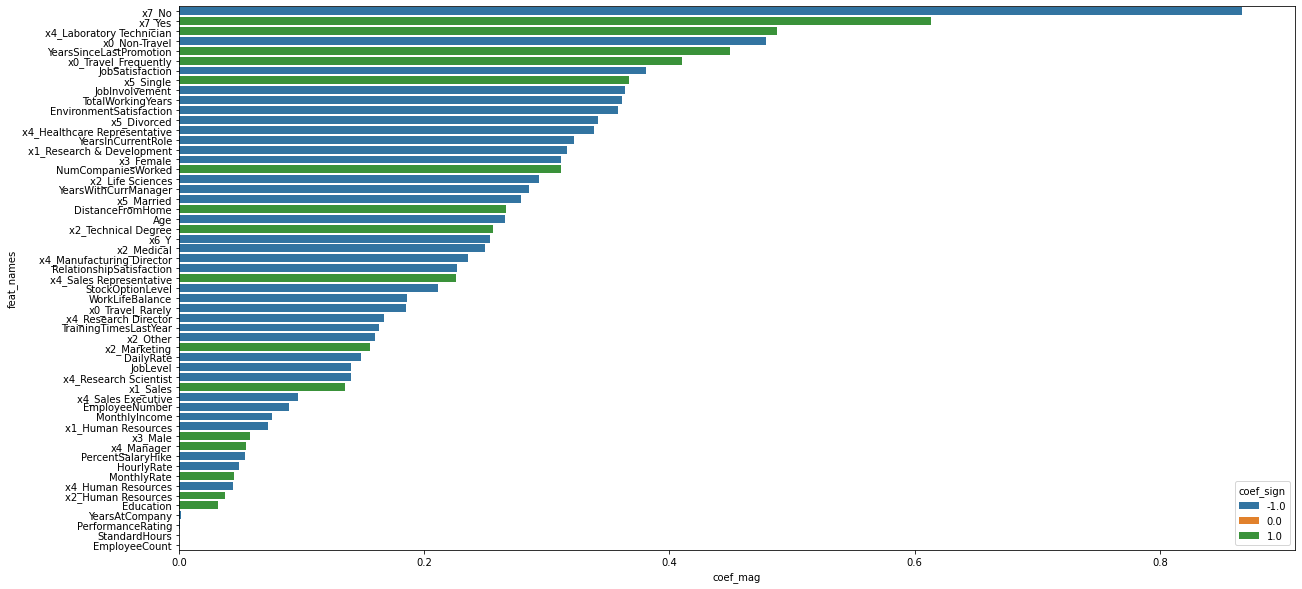

In [ ]:
# TODO: feel free to uncomment and edit the code below to obtain your feature importance graph. 
# Did the graph surprise you? What features did you think were more important?

# #get names in correct preproc order
cat_names = reg_grid_search.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names()
num_names = reg_grid_search.best_estimator_.named_steps['preproc'].transformers_[1][2]

# #create df with vip info
coef_info = pd.DataFrame({'feat_names':np.hstack([cat_names, num_names]), 'vip_reg': vip_reg})

# #get sign and magnitude information
coef_info = coef_info.assign(coef_mag = abs(coef_info['vip_reg']),coef_sign = np.sign(coef_info['vip_reg']))

# #sort and plot
coef_info = coef_info.set_index('feat_names').sort_values(by='coef_mag', ascending=False)
plt.figure(figsize = (20,10))
sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False)

## Performance metrics on test data


Here, we can see the performance of the model, which is pretty nice! We can also look into different scores specifically for more insight into the performance.

In [ ]:
# TODO: print your classification report of your model

reg_result = (classification_report(y_test, reg_grid_search.best_estimator_.predict(X_test)))
print(reg_result)

for_result = (classification_report(y_test, for_grid_search.best_estimator_.predict(X_test)))
print(for_result)

grad_result = (classification_report(y_test, grad_grid_search.best_estimator_.predict(X_test)))
print(grad_result)

              precision    recall  f1-score   support

          No       0.88      0.99      0.93       309
         Yes       0.83      0.32      0.46        59

    accuracy                           0.88       368
   macro avg       0.86      0.65      0.70       368
weighted avg       0.87      0.88      0.86       368

              precision    recall  f1-score   support

          No       0.85      1.00      0.92       309
         Yes       0.83      0.08      0.15        59

    accuracy                           0.85       368
   macro avg       0.84      0.54      0.54       368
weighted avg       0.85      0.85      0.80       368

              precision    recall  f1-score   support

          No       0.89      0.95      0.92       309
         Yes       0.62      0.39      0.48        59

    accuracy                           0.86       368
   macro avg       0.76      0.67      0.70       368
weighted avg       0.85      0.86      0.85       368



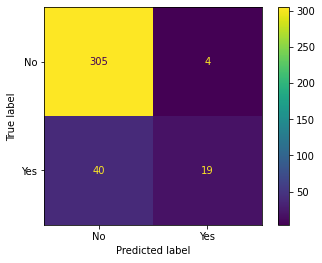

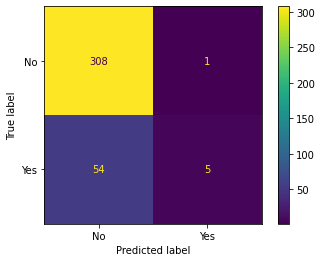

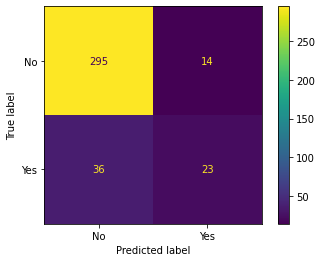

In [ ]:
#  plot the confusion matrix graph for Regression 

cm = confusion_matrix(y_test, reg_grid_search.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=reg_grid_search.classes_)
disp.plot()

cm = confusion_matrix(y_test, for_grid_search.best_estimator_.predict(X_test))
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=for_grid_search.classes_)
disp2.plot()

cm = confusion_matrix(y_test, grad_grid_search.best_estimator_.predict(X_test))
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=grad_grid_search.classes_)
disp3.plot()


plt.show()

## Business Value for Each Model


**Cost Assumptions:**

Cost of replacing an employee is $120,000 (RC)

Cost of intervention $2,000 used on each employee predicted to leave (IC)

Intervention success rate is 20% (SR)



```
Linear Regression: 19(TP)*120000*.2 - 2000*23(TP+FP) = $410K

Random Forest: 5(TP)*120000*.2 - 2000*6(TP+FP) = $108k

Gradient Descent: 23(TP)*120000*.2 - 2000*37(TP+FP) = $478k
```



**Gradient Descent is the winner at +$478k**

This is even though it is less accurate on average than the regression since it is better to try minimizing false positives given the payoffs.


## Feature Engineering for HW6

I already did the feature engineering last week to get things to work properly using the pipelines! and i'll explain two of the features that I engineered below!

**1. Dummy Variabless for Department**

a. I performed feature engineering on the department varaible because we want to transform it from an object into a series of dummy variables that the model can use. 

b. I transformed the feature by using the pipeline's onehotencoder feature with a list of categorical variables found by selecting all of the object columns. It would then transform these objects into dummy variables with a new column for each category.

c. The rational for turning the department into dummary variables is that the departments definitely play in important role in turnover since management could be poor in a certain department, wages could be below avg. etc. 

d. A unit test for this would be to confirm the dtype is a boolean and that all of the columns in a row created from the department column sum to 1.


**2. Dummy Variables for Role**

a. Similar to the above, i also performed feature engineering on the job role to column to create dummy variables for each role.

b. I used the same process as above since the onehotencoder was generalized to create dummy variable categories from each of the object columns (which job role is)

c. The rational for turning the role into dummary variables is that the roles are very important and have little relationship with one another. EG There isn't any real proximity measurement between lab technician, Healcare rep, and Healthcare director. It is definitely best to have them all as seperate dumym variables.

d. Identical to above, the units test should confirm the dtype is a boolean and that all of the columns in a row created from the role column sum to 1.

## Extra Credit 1

The onehotencoder with the columntransformer that is used above is an example of how to incorporate feature engineering into a pipeline. If we have a number a categorical varaible that is an object type, then we can set-up
a ColumnTransformer to process it into a dummy variable using the OneHotEncoder as a step in the pipeline.


```
# Example from Above

cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                               ('onehot_cat', OneHotEncoder())])


categorical_features = X_train.select_dtypes(include="object").columns


preproc = ColumnTransformer([('cat_pipe', cat_pipeline, categorical_features)])

```


